![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

In [4]:
#!pip install plotly
!pip install distance


  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16265 sha256=ef441e319fc194ae7536dbf55791683cffb1a4645752b2ecdc99e67331381c3f
  Stored in directory: c:\users\vishal\appdata\local\pip\cache\wheels\b2\10\1b\96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [6]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [7]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

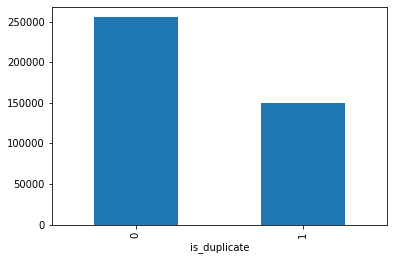

In [9]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [10]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [11]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [12]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



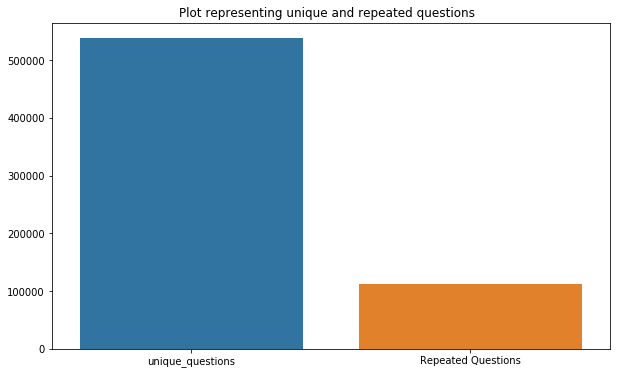

In [0]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [13]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



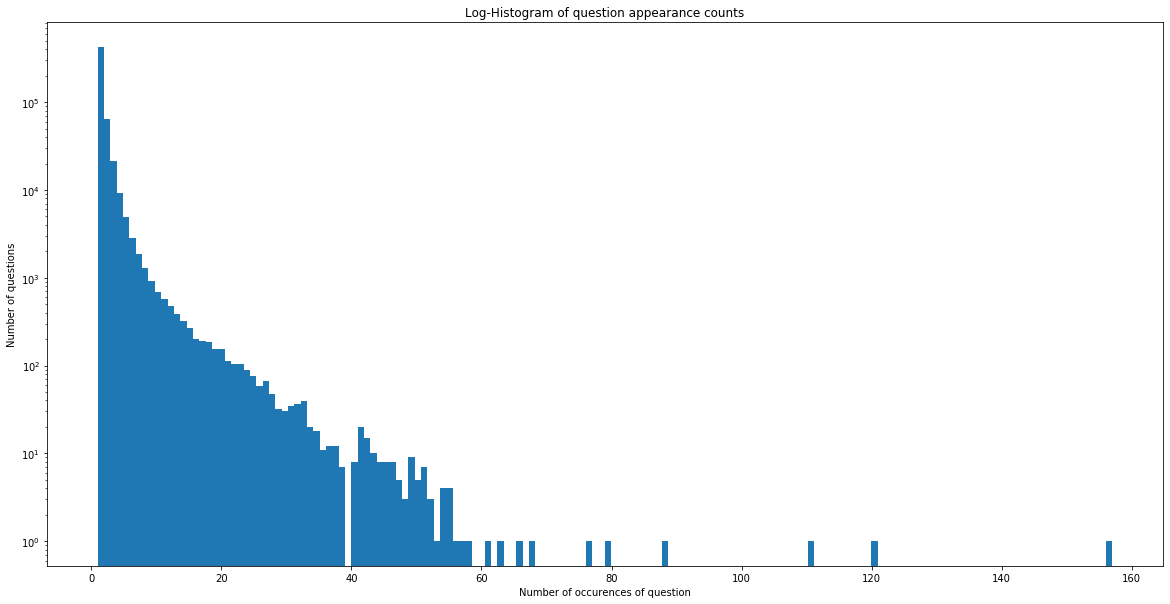

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [16]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [26]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

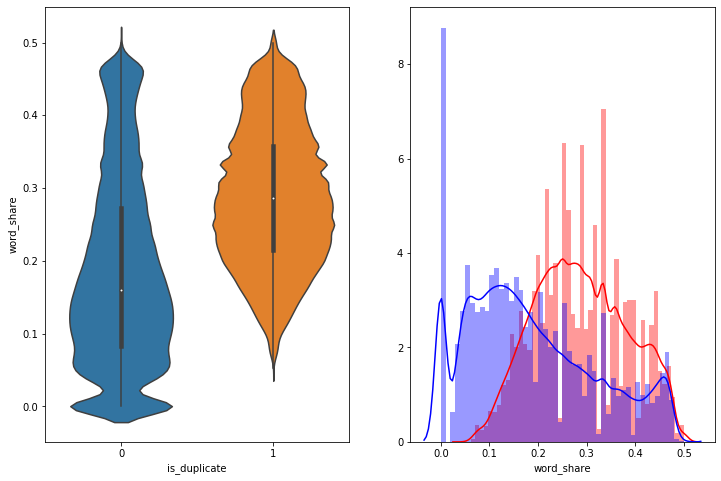

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

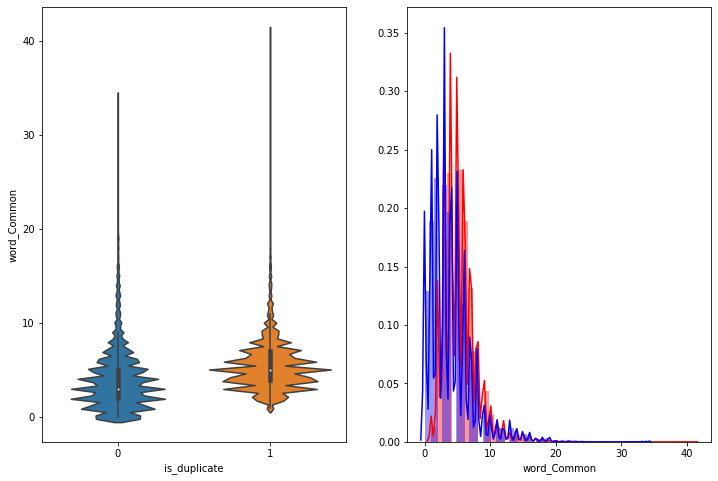

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [23]:
!pip install mlxtend

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [25]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

FileNotFoundError: [Errno 2] No such file or directory: 'final_features.csv'